In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
batch_size = 16
image_size = 64

# Create the dataset
anime_faces_dataset = datasets.ImageFolder(
    root=os.path.join(os.getcwd(), 'data', 'anime-class'),
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),  # Crop out the center to get 64x64 images
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [5]:
len(anime_faces_dataset)  # Check the length of the dataset

2048

In [4]:
classes = anime_faces_dataset.classes

classes

['good_fake_images', 'real_images']

In [6]:
train_set, test_set = data.random_split(anime_faces_dataset, [1640, 408])

In [7]:
trainloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape

torch.Size([16, 3, 64, 64])

real_images real_images good_fake_images good_fake_images good_fake_images real_images real_images real_images


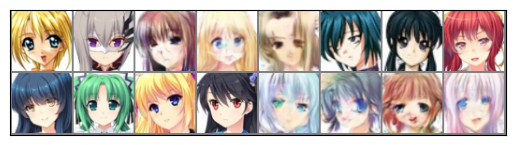

real_images real_images real_images real_images good_fake_images good_fake_images good_fake_images good_fake_images


In [13]:
def display(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.permute(1, 2, 0)  # change from (C, H, W) to (H, W, C)
    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

display(make_grid(images, 8))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [14]:
# Number of channels in the training images.
nc = 3

# Size of the feature maps in the discriminator.
ndf = 64

# Learning rate for optimizers
lr = 0.0002

In [15]:
def weight_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True), # Shows to improve the performance of the discriminator

            # State size: (ndf) x 32 x 32
            nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2), # Normalizes the output of the previous layer to have mean 0 and variance 1 Helps mitigate problems
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*2) x 16 x 16
            nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*4) x 8 x 8
            nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*8) x 4 x 4
            nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()  # Output is between 0 and 1
        )

    def forward(self, x):
        return self.main(x)


In [17]:
netD = Discriminator().to(device)
netD.apply(weight_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [18]:
criterion = nn.BCELoss() # Binary Cross Entropy Loss

optimizer = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999)) # Adaptive learning rate optimizer

In [24]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = netD(inputs)

        loss = criterion(outputs.flatten(), labels.float())

        # Backward pass and optimize
        loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # Print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # Print every 20 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
        


print('Finished Training')

[Epoch 1, Batch 1] loss: 0.000
[Epoch 1, Batch 21] loss: 0.053
[Epoch 1, Batch 41] loss: 0.036
[Epoch 1, Batch 61] loss: 0.015
[Epoch 1, Batch 81] loss: 0.033
[Epoch 1, Batch 101] loss: 0.015
[Epoch 2, Batch 1] loss: 0.000
[Epoch 2, Batch 21] loss: 0.008
[Epoch 2, Batch 41] loss: 0.005
[Epoch 2, Batch 61] loss: 0.005
[Epoch 2, Batch 81] loss: 0.006
[Epoch 2, Batch 101] loss: 0.008
[Epoch 3, Batch 1] loss: 0.001
[Epoch 3, Batch 21] loss: 0.002
[Epoch 3, Batch 41] loss: 0.002
[Epoch 3, Batch 61] loss: 0.002
[Epoch 3, Batch 81] loss: 0.002
[Epoch 3, Batch 101] loss: 0.002
[Epoch 4, Batch 1] loss: 0.000
[Epoch 4, Batch 21] loss: 0.001
[Epoch 4, Batch 41] loss: 0.002
[Epoch 4, Batch 61] loss: 0.001
[Epoch 4, Batch 81] loss: 0.001
[Epoch 4, Batch 101] loss: 0.001
[Epoch 5, Batch 1] loss: 0.000
[Epoch 5, Batch 21] loss: 0.001
[Epoch 5, Batch 41] loss: 0.001
[Epoch 5, Batch 61] loss: 0.000
[Epoch 5, Batch 81] loss: 0.001
[Epoch 5, Batch 101] loss: 0.001
Finished Training


GroundTruth:  good_fake_images good_fake_images real_images real_images real_images good_fake_images good_fake_images real_images


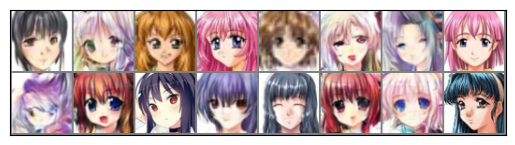

good_fake_images good_fake_images real_images good_fake_images real_images good_fake_images good_fake_images real_images


In [25]:
dataiter = iter(testloader)

images, labels = next(dataiter)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [26]:
outputs = netD(images.to(device))

Predicted:  good_fake_images good_fake_images real_images real_images good_fake_images good_fake_images good_fake_images real_images


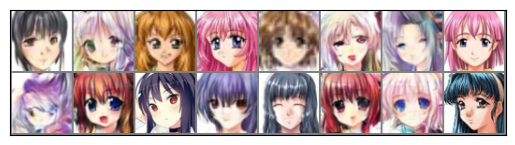

Predicted:  good_fake_images good_fake_images real_images good_fake_images real_images good_fake_images good_fake_images real_images


In [27]:
predicted = torch.round(outputs.flatten())

print('Predicted: ', ' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print('Predicted: ', ' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8, 16)))


In [ ]:
correct = {classname: 0 for classname in classes} 
total = {classname: 0 for classname in classes}

all_labels = []
all_predicted = []

# Count the correct predictions for each class and calculate accuracy
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = netD(images)
        predicted = torch.round(outputs.flatten())

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct[classes[label]] += 1
            total[classes[label]] += 1

for classname, correct_count in correct.items():
    accuracy = 100 * float(correct_count) / total[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:.2f}%')

Accuracy for class good_fake_images is 99.49%
Accuracy for class real_images is 97.18%
